In [1]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers

from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from keras.applications import ResNet50

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import cv2
import os
#import shutil

from PIL import Image

2024-02-03 15:02:37.386209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 15:02:37.386267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 15:02:37.442430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 15:02:37.580449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 15:02:38.643619: W tensorflow/compiler/tf2

In [2]:
#classification

def generate_model(input_shape):
    inputs = layers.Input(shape=input_shape)  # input layer 
    #vgg19 = k.applications.VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    #x = vgg19(inputs, training=False)
    densenet121 = k.applications.DenseNet121(include_top=False, input_tensor=inputs)  # use DenseNet121 
    x = densenet121(inputs, training=True)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    #classi layers
    for filters in [128]:#, 256]:#, 320]:#, 512]:#, 1024, 2048]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    #output
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Flatten()(x)
    #x = layers.Dense(128, activation="relu")(x)
    output = layers.Dense(7, activation="softmax")(x)

    model = k.Model(inputs=inputs, outputs=output, name="classification")
    return model

classification = generate_model((256,256,3))
classification.summary()

#classification.save("classification.keras")

2024-02-03 15:02:40.637199: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-03 15:02:40.854243: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-03 15:02:40.854298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-03 15:02:40.856626: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-03 15:02:40.856677: I external/local_xla/xla/stream_executor

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          589888    
                                                                 
 activation (Activation)     (None, 8, 8, 64)          0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 64)          256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                    

In [3]:
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

#weighted binary loss
def get_weights(df):
    # for each label , calculate the fraction of the label among totaility
    total = len(df)
    weight_dict = { "mel":0, "nv":0, "bcc":0, "akiec":0, "bkl":0, "df":0, "vasc":0 }
    label_to_index_dict = { "mel":0, "nv":1, "bcc":2, "akiec":3, "bkl":4, "df":5, "vasc":6 }
    class_weight_dict = { 0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0 } 
    for dx in weight_dict.keys():
        weight_dict[dx] = 1.0 - (len(df[df['dx'] == dx]) / total)
        label_index = label_to_index_dict.get(dx)
        class_weight_dict[label_index] = weight_dict[dx]
    return class_weight_dict
    
# def get_weights(labels):
#     cols = len(labels.columns)-2 #assumes 1 column for image ids
#     weights = {}
#     for i in range(cols+1):
#         weights[i] = 1-np.mean(labels[labels.columns[i+1]].tolist())
#     return weights




from keras import backend as K
def f_score(y_true, y_pred, threshold=0.1, beta=2):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))

def tp_score(y_true, y_pred, threshold=0.1):
    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    return tp

def fp_score(y_true, y_pred, threshold=0.1):
    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )

    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    return fp

def fn_score(y_true, y_pred, threshold=0.1):
    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))
    return fn

def precision_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    return tp / (tp + fp)

def recall_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    return tp / (tp + fn)


In [4]:
cls_datagen = ImageDataGenerator(rotation_range=0,
                                horizontal_flip=True,
                                vertical_flip=True,
                                width_shift_range=0.15,
                                height_shift_range=0.15
                                )

In [5]:
# For loading classification labels and images.
# Standard Function, random sampling
def load_images_and_labels(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    for i in range(batch_size):
        random_index = np.random.randint(0, len(images)-2)
        if random_index >= len(images):
            random_index -=1
        img = cv2.imread(os.path.join(images_path, images[random_index]))
        row = labels.iloc[random_index, 1:]

        if img is not None and row is not None:
            if random_index not in data_indexes:
                data_indexes.append(random_index)
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

# Equal Sampling
def load_images_and_labels_equal(images_path, labels_path, batch_size, num_classes, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    samples_per_class = []
    class_indexes = []
    labels = pd.read_csv(labels_path)
    class_names = np.array(labels.columns[1:])
    images = os.listdir(images_path)
    for i in range(num_classes):
        samples_per_class.append(batch_size//num_classes)
    for i in range(batch_size%num_classes):
        samples_per_class[i] += 1
    instances_per_class = labels.sum(axis=0, numeric_only=True)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path} with equal sampling")
    for i in range(num_classes):
        #get all row indexes with 1 in ith row
        class_indexes = []
        p = 0
        for x in labels.iloc:
            if x[i+1] == 1:
                class_indexes.append(p)
            p+=1
        print(f"samples for {i} class: {samples_per_class[i]}, class_indexes len: {len(class_indexes)}")
        for x in range(samples_per_class[i]):
            random_index = np.random.randint(0, instances_per_class[i])
            ind = class_indexes[random_index]
            img = cv2.imread(os.path.join(images_path, images[ind]))
            row = labels.iloc[ind, 1:]
            if img is not None and row is not None:
                if not (samples_per_class[i] >= len(class_indexes)-1):               
                    class_indexes.pop(random_index)
                    instances_per_class[i] -= 1
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape), dtype="uint8"))
                #assuming 1 column for image id
                #ds_labels.append(row.values) #for array labels
                ds_labels.append(class_names[np.where(row.values == 1)[0][0]]) #for string labels - make sure to remove .astype for labels
                #ds_labels.append(np.where(row.values == 1)[0][0]) #for integer labels
        print("1 class loaded")
        print(f"len ds_images: {len(ds_images)}")
        print(f"len ds_labels: {len(ds_labels)}")
    return np.array(ds_images).astype(np.uint8), pd.get_dummies(ds_labels).to_numpy()#k.utils.to_categorical(ds_labels, num_classes=num_classes)


In [6]:
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"
df_val_meta = pd.read_csv(cls_val_gt)

df_val_meta['img_name'] = df_val_meta['image'] + ".jpg"

df_val_meta['bits_num'] = df_val_meta['MEL'] * 1 + df_val_meta['NV'] * 2 + df_val_meta['BCC'] *4 + df_val_meta['AKIEC']*8 +  \
    df_val_meta['BKL']*16 + df_val_meta['DF']*32 + + df_val_meta['VASC']*64

label_dict = { 1.0 :"mel", 2.0:"nv", 4.0:"bcc", 8.0:"akiec", 16.0:"bkl", 32.0:"df", 64.0:"vasc" }
def to_dx(bits_num):
    return label_dict.get(bits_num)

df_val_meta["dx"] = df_val_meta["bits_num"].apply(to_dx)

df_val_meta.sample(5)


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_name,bits_num,dx
117,ISIC_0034445,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034445.jpg,2.0,nv
151,ISIC_0034482,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034482.jpg,1.0,mel
162,ISIC_0034493,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0034493.jpg,16.0,bkl
120,ISIC_0034448,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034448.jpg,2.0,nv
174,ISIC_0034505,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0034505.jpg,16.0,bkl


In [7]:
cls_train_gt_ham10000 = 'ham10000/HAM10000_metadata.csv'
df_train= pd.read_csv(cls_train_gt_ham10000)
df_train['img_name'] = df_train['image_id'] + ".jpg"

df_train.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,img_name
646,HAM_0006181,ISIC_0030849,bkl,histo,65.0,male,upper extremity,ISIC_0030849.jpg
5506,HAM_0002272,ISIC_0025371,nv,follow_up,65.0,male,back,ISIC_0025371.jpg
7495,HAM_0003824,ISIC_0032971,nv,histo,15.0,female,lower extremity,ISIC_0032971.jpg
7865,HAM_0004118,ISIC_0032593,nv,histo,30.0,female,trunk,ISIC_0032593.jpg
3915,HAM_0001008,ISIC_0031898,nv,follow_up,50.0,female,back,ISIC_0031898.jpg


In [8]:
# see get_weights for each labels for training

get_weights(df_train)

{0: 0.888866699950075,
 1: 0.3305042436345482,
 2: 0.9486769845232151,
 3: 0.9673489765351972,
 4: 0.8902646030953569,
 5: 0.9885172241637543,
 6: 0.9858212680978532}

In [9]:
# see get_weights for each labels for validation

get_weights(df_val_meta)

{0: 0.8911917098445596,
 1: 0.36269430051813467,
 2: 0.9222797927461139,
 3: 0.9585492227979274,
 4: 0.8860103626943006,
 5: 0.9948186528497409,
 6: 0.9844559585492227}

In [10]:
#classification = k.models.load_model('classification.keras') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
classification.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f_score, precision_score, 'AUC']) 

callback_list = []#[tf.keras.callbacks.EarlyStopping(patience=1.5)] #can adjust to improve accuracy
"""
batch_size=32
spe = 2 #steps per epoch
epochs = 50 # set to 1 for debugging purposes
"""

seed = 123

cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
#cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

cls_train = r'train/ISIC2018_Task3_Training_Input/'#r"classi/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/" 
#cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")


epochs=20
batch_size = 2
spe=4
"""
length=len(pd.read_csv(cls_train_gt))//64
b_max= 60 # set this based on  how much your  memory can hold
batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and 
                  length/n<=b_max],reverse=True)[0] 
spe=int(length/batch_size)
"""


print(batch_size*spe*epochs)

# train_ds, train_gt = load_images_and_labels_equal(cls_train, cls_train_gt, batch_size*spe*epochs, 7, (256,256), True)
# val_ds, val_gt = load_images_and_labels_equal(cls_val, cls_val_gt, batch_size*spe*epochs//2, 7, (256,256), True)


# setup training dataset and validation dataset


train_data = cls_datagen.flow_from_dataframe(dataframe=df_train, directory=cls_train, x_col="img_name", y_col="dx", \
                                             target_size=(256,256), batch_size=epochs*batch_size*spe, shuffle=True)
validation_data = cls_datagen.flow_from_dataframe(dataframe=df_val_meta, directory=cls_val, x_col="img_name", y_col="dx", \
                                                  target_size=(256,256), batch_size=epochs*batch_size*spe, shuffle=True)

#print(f"train_ds len: {len(train_ds)}, train labels len: {len(train_gt)}")
#print(f"val_ds len: {len(val_ds)}, val labels len: {len(val_gt)}")

# cls_train_gen = cls_datagen.flow(x=train_ds, y=train_gt, seed=seed, batch_size=batch_size*spe, shuffle=False)
# val_train_gen = cls_datagen.flow(x=val_ds, y=val_gt, seed=seed, batch_size=batch_size*spe//2, shuffle=False)


# history = classification.fit(cls_train_gen, steps_per_epoch=len(cls_train_gen.x)//cls_train_gen.batch_size, epochs=epochs,
#                                 #class_weight=get_weights(pd.read_csv(cls_train_gt)), 
#                                 batch_size=batch_size, callbacks=callback_list, verbose=1,
#                                 validation_data=(val_train_gen.x, val_train_gen.y), validation_steps=len(val_train_gen.x)//val_train_gen.batch_size)

print(f"--------------- start training -----------------")

history = classification.fit(train_data, steps_per_epoch=spe, epochs=epochs,
                                class_weight=get_weights(df_train), 
                                batch_size=batch_size, callbacks=callback_list, verbose=1,
                                validation_data=validation_data, validation_steps=spe)

print(f"--------------- Done training -----------------")

classification.save_weights("classification_final_3.h5")


160


Found 10015 validated image filenames belonging to 7 classes.
Found 193 validated image filenames belonging to 7 classes.
--------------- start training -----------------
Epoch 1/20


2024-02-03 15:02:59.746176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inclassification/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-03 15:03:03.566998: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-03 15:03:03.625469: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-03 15:03:03.931516: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-03 15:03:15.689451: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 320.00MiB (rounded to 335544320)requested by op classification/densenet121/conv2_block4_1_bn/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment va

ResourceExhaustedError: Graph execution error:

Detected at node classification/densenet121/conv2_block4_1_bn/FusedBatchNormV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/danny/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/danny/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/danny/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/danny/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/danny/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/danny/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/danny/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/danny/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/danny/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/danny/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/danny/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/danny/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/danny/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/danny/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/danny/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/danny/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/danny/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/danny/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/danny/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_32499/165485322.py", line 61, in <module>

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[160,128,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node classification/densenet121/conv2_block4_1_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_33454]

(450, 600, 3)
(256, 256, 3)
1/1 [==============================] - 3s 3s/step
True Label:            image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
71  ISIC_0034596  0.0  0.0  0.0    0.0  1.0  0.0   0.0
Predicted Scores: [[0.06108923 0.02101576 0.49388093 0.01784678 0.05285696 0.23285656
  0.12045382]]


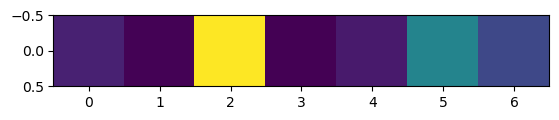

This image most likely belongs to BCC with a 49.39 percent confidence.


In [ ]:
#Individual Image Testing
class_names=["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

pred_folder = "test/ISIC2018_Task3_Test_Input"
pred_image = "ISIC_0034596"
labels_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"
#classification = k.models.load_model("final_class.keras", custom_objects={"f_score": f_score, "precision_score": precision_score}) # make sure to run only after training the classification model


pred_label_df = pd.read_csv(labels_path)
pred_label_true = pred_label_df.loc[pred_label_df['image']==pred_image]

test_image = np.array(cv2.imread(os.path.join(pred_folder, pred_image) + ".jpg"))
print(test_image.shape)
#plt.imshow(test_image, interpolation='nearest')
#plt.show()

pred_image = cv2.resize(test_image, (256,256))
print(pred_image.shape)

img_array = tf.keras.utils.img_to_array(pred_image)
img_array = tf.expand_dims(img_array, 0) # Create a batch

score = classification.predict(img_array)
"""
TF_MODEL_FILE_PATH = 'cls_final_withresampling3.tflite' # The default path to the saved TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
sig_dict = interpreter.get_signature_list()
print(f"sig_dict = {sig_dict}")
sig = list(sig_dict)[0]
print(f'sig = {sig}')
classify_lite = interpreter.get_signature_runner('serving_default')
print(classify_lite)
predictions_lite = classify_lite(input_2=img_array)['dense_2']
score_lite = tf.nn.softmax(predictions_lite)
"""
label_name = class_names[np.argmax(score)]
confidence_percent = 100 * np.max(score)


print(f"True Label: {pred_label_true}")

print(f"Predicted Scores: {score}")
plt.imshow(score, interpolation="nearest")
plt.show()

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(label_name, confidence_percent))

Evaluation Graph Scripts

In [ ]:
#eval
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
#train_acc  = history.history['acc']
#val_acc    = history.history['val_acc']
xc         = range(10)

plt.figure()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(xc, train_loss)
#plt.plot(xc, val_loss)

In [ ]:
x_test_path = "test/ISIC2018_Task3_Test_Input"
y_test_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"

x_test, y_test = load_images_and_labels(x_test_path, y_test_path, len(pd.read_csv(y_test_path)), (256,256), True)

y_prediction = classification.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(result, cmap=plt.cm.Blues, alpha=0.3)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        ax.text(x=j, y=i,s=np.round(result[i, j], 3), va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

NameError: name 'load_images_and_labels' is not defined

In [ ]:
def convert_to_tflite(model, name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model.
    with open(str(name), 'wb') as f:
      f.write(tflite_model)

In [ ]:
convert_to_tflite(classification, "cls_final.tflite")

KeyboardInterrupt: 

In [ ]:
classification.save("classification_final.keras")

KeyboardInterrupt: 

: 